In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import polars as pl
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power
%matplotlib inline
%load_ext autoreload
%autoreload 2
from src.simulations import *
from src.plotting import *
from src.modeling import *
#Convert effect sizes from r to Cohen's D 
r_to_d = lambda r: (2*r)/np.sqrt(1-r**2)

In [2]:
get_tc = lambda n: (1/np.sqrt(n))* sp.stats.t.ppf(1.0 - .05, n-2)


<h1>Psychology RPP</h1>

In [3]:
#Load RPP Data, randomize direction. 


df_psych = pl.read_csv('./data/rpp_data.csv',ignore_errors=True).filter(
    (pl.col('T_pval_USE..R.').is_not_null()) & 
    (pl.col('T_pval_USE..O.').is_not_null()) &
    (pl.col('T_r..R.').is_not_null()) &
    (pl.col('T_r..O.').is_not_null()) 
)

direction = np.random.choice(np.array([-1,1]), 
                             df_psych.shape[0])

df_psych = df_psych.with_column(
    (pl.lit(direction)).alias('direction')  
).with_columns([
    (r_to_d(pl.col('T_r..R.').cast(float))).alias("d_r"),
    (r_to_d(pl.col('T_r..O.').cast(float))).alias("d_o"),
    pl.col('N (R)').cast(int).alias("n_r"),
    pl.col('N (O)').cast(int).alias("n_o"),
]).with_column(
    (pl.col('n_o').apply(get_tc)).alias('t_temp')
).with_column(
    (pl.col('t_temp') * pl.col('direction')).alias('t_c')
).select([
    'd_o','d_r','n_o','n_r','direction','t_c'
]).with_columns(
    [pl.when(pl.col('d_o')*pl.col('direction') > pl.col('t_c')).then(1000).otherwise(pl.col('t_c')).alias('upper'),
    pl.when(pl.col('d_o')*pl.col('direction') < pl.col('t_c')).then(-1000).otherwise(pl.col('t_c')).alias('lower'),
    ])

df_psych.head()

d_o,d_r,n_o,n_r,direction,t_c,upper,lower
f64,f64,i64,i64,i64,f64,f64,f64
1.479085,0.3,24,29,-1,-0.350511,-0.350511,-1000.0
1.544133,0.471814,24,24,1,0.350511,1000.0,0.350511
0.938971,-0.4408,25,32,-1,-0.342774,-0.342774,-1000.0
0.469938,-0.012217,240,270,1,0.1065,1000.0,0.1065
1.039851,0.272108,32,48,-1,-0.300036,-0.300036,-1000.0


In [4]:
idata_psych, m_psych = sample_publishing_model(df_psych.to_pandas(), prior={'s':2,
                                                                        't':2})

/Users/joebak/github/ReplicationSurveys/src/modeling.py:41: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  prior_checks = pm.sample_prior_predictive(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/joebak/anaconda3/envs/rs/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, signal]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
/Users/joebak/github/ReplicationSurveys/src/modeling.py:59: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.
  ppc = pm.sample_posterior_predictive(


In [5]:
az.summary(idata_psych, var_names=['tau','sigma',])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.801,0.086,0.646,0.971,0.002,0.001,1725.0,2054.0,1.0
sigma,0.606,0.058,0.491,0.709,0.002,0.001,1369.0,2009.0,1.0


In [6]:
make_summary_table(idata_psych, './output/tables/psych_posterior.tex')

/Users/joebak/github/ReplicationSurveys/src/modeling.py:77: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(save_loc)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
sigma,0.61,0.06,0.49,0.71,0.0,0.0,1369.0,2009.0,1.0
tau,0.80,0.09,0.65,0.97,0.0,0.0,1725.0,2054.0,1.0


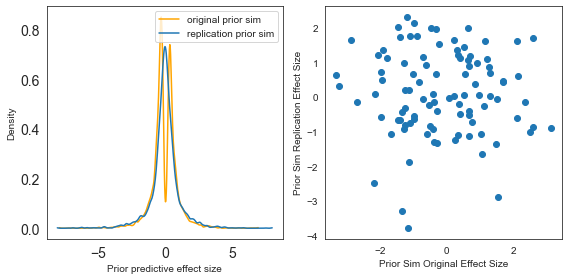

In [7]:
plot_prior_checks(idata_psych.prior_predictive, './output/figures/SIPriorRPP.png')

/Users/joebak/github/ReplicationSurveys/src/plotting.py:85: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


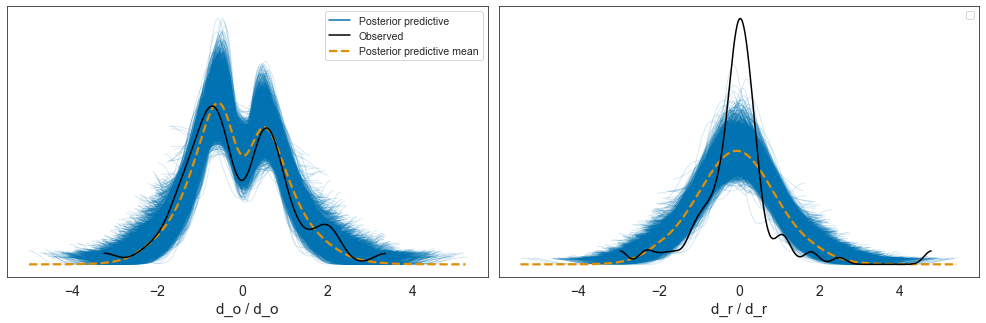

In [8]:
plot_posterior_distribution(idata_psych,save_loc='./output/figures/PosteriorDistributionRPP.png')

In [9]:
out_psych = simulate(idata_psych,j=500,save_loc='./output/psych_sims.csv')

/Users/joebak/anaconda3/envs/rs/lib/python3.10/site-packages/polars/internals/frame.py:1097: UserWarning: 'to_csv' is deprecated. please use 'write_csv'
  warnings.warn("'to_csv' is deprecated. please use 'write_csv'")


In [10]:
out_psych.head()

publication_rate,replication_rate,type_s_error,published_es,actual_es,reversals,replication_es,N,j,alpha
f64,f64,f64,f64,f64,f64,f64,i64,i64,f64
0.076502,0.131815,0.019076,1.4199,0.960093,0.002512,0.959686,10,500,0.005
0.1139,0.176405,0.024124,1.424969,0.957916,0.004554,0.961502,10,500,0.01
0.25424,0.309888,0.04578,1.286435,0.870711,0.017537,0.870299,10,500,0.05
0.351874,0.382153,0.060268,1.202365,0.830363,0.030771,0.830807,10,500,0.1
0.47648,0.461035,0.082476,1.088991,0.768757,0.0578,0.768566,10,500,0.2


In [42]:
from src.plotting import *

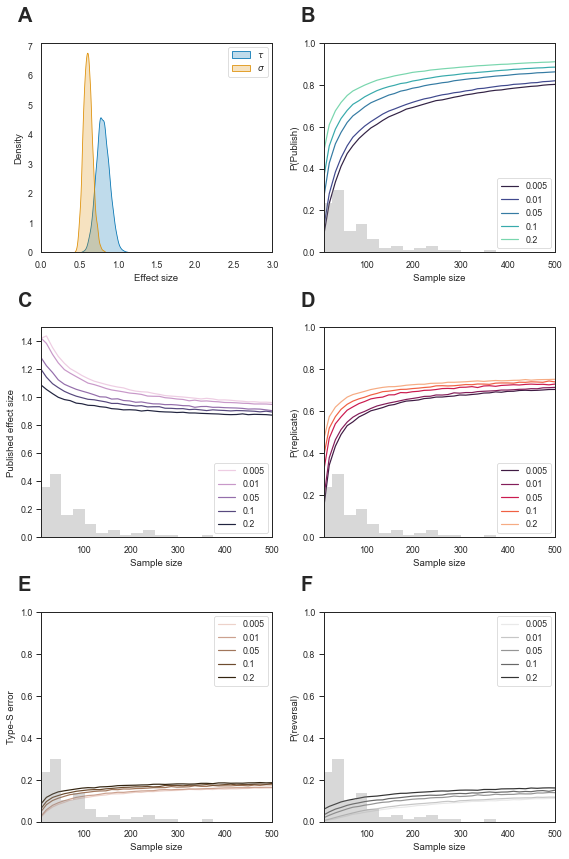

In [43]:
plot_sim_figure(idata_psych, out_psych.to_pandas(),
                df_psych.to_pandas(),plot_medians=False,
                save_loc='./output/figures/Figure4.png',max_effect=3)

#add average effect

